In [1]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fitting.utils import get_lab_example
from fitting.utils import get_output_dirs

save_outputs = False
results_dir = '/home/mattw/results/behavenet_figs/'

# Plot decoder $R^2$'s

### load results

In [10]:
# specify decoder directory
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet'}
lab = 'musall'
model_types = ['linear', 'ff']
expt_name = 'grid_search'

metrics = []
model_indx = 0
model_counter = 0
for model_type in model_types:

    get_lab_example(hparams, lab)
    
    _, _, expt_dir = get_output_dirs(
        hparams, model_class='neural-ae', expt_name=expt_name, model_type=model_type)

    # gather all versions
    def get_dirs(path):
        return next(os.walk(path))[1]
    versions = get_dirs(expt_dir)

    # load csv files with model metrics (saved out from test tube)
    for i, version in enumerate(versions):
        # read metrics csv file
        model_dir = os.path.join(expt_dir, version)
        try:
            metric = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
            model_counter += 1
        except:
            continue
        # load model info
#         with open(os.path.join(model_dir, 'meta_tags.csv'), mode='r') as f:
#             hp = csv.reader(f)
#             hparams = {rows[0]: rows[1] for rows in hp}
        with open(os.path.join(model_dir, 'meta_tags.pkl'), 'rb') as f:
            hparams = pickle.load(f)
        # append model info to metrics ()
        version_num = version[8:]
        metric['version'] = str('version_%i' % model_indx + version_num)
        for key, val in hparams.items():
            if isinstance(val, (str, int, float)):
                metric[key] = val
        metrics.append(metric)
        
    model_indx += 10000  # assumes no more than 10k model versions in an experiment
# put everything in pandas dataframe
metrics_df = pd.concat(metrics, sort=False)
print('Loaded %i models for analysis' % model_counter)

Loaded 375 models for analysis


### Plot R2s as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [11]:
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
best_models_list = []

if 'ff' not in model_types:
    hue = None
else:
    hue = 'n_hid_layers'
    
# take min over val losses
loss_mins = metrics_df.groupby(
    ['n_lags', 'n_hid_layers', 'learning_rate', 'l2_reg', 'version']).min().reset_index()
n_lags = metrics_df.n_lags.unique()
n_lags.sort()
n_hid_layers = metrics_df.n_hid_layers.unique()
n_hid_layers.sort()
for lag in n_lags:
    for layer in n_hid_layers:
        # get all models with this number of lags
        single_hp = loss_mins[(loss_mins.n_lags==lag) & (loss_mins.n_hid_layers==layer)]
        # find best version from these models
        best_version = loss_mins.iloc[single_hp.val_loss.idxmin()].version
        # index back into original data to grab test loss on all batches
        best_models_list.append(data_queried[data_queried.version==best_version])

best_models_df = pd.concat(best_models_list)

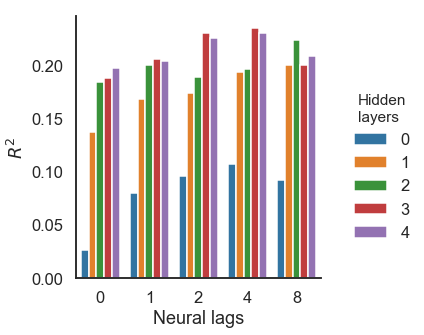

In [12]:
# PLOT
sns.set_style('white')
sns.set_context('talk')

y_axis = 'test_r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=best_models_df, ci=None)
if y_axis == 'test_r2':
    splt.ax.set_ylabel('$R^2$')
elif y_axis == 'test_loss':
    splt.ax.set_ylabel('MSE')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')

if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_by_trial' % lab)
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

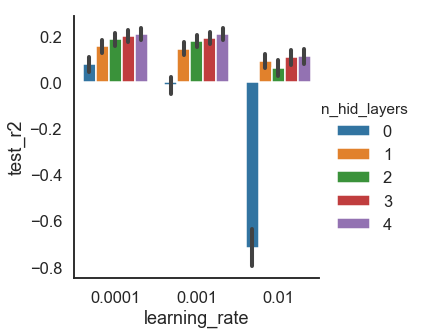

In [14]:
# look at reg vals/learning rate
measure = 'learning_rate'  # 'learning_rate' | 'l2_reg'

if measure == 'learning_rate':
    get_best = 'l2_reg'
else:
    get_best = 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

x_axis = measure
y_axis = 'test_r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
hue = 'n_hid_layers'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)

# make movies

In [6]:
# from analyses.ae.movies import reconstruction
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
from analyses.ae_movies import make_neural_reconstruction_movie

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'test_pt',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best',
    'lib': 'pt'}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:

get_lab_example(hparams, lab)
# fastest way to get test trials
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=['images'], transforms=[None], load_kwargs=[None],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.batch_indxs[0]['test'][4]

if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_%02i_dim_recon_neural' % (lab, hparams['n_ae_latents']))
    make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
else:
    pass   

# Calculate R2 over entire test data

### get best models from before

In [7]:
def get_test_r2(hparams, model_version):
    
    from sklearn.metrics import r2_score
    from fitting.utils import get_best_model_and_data
    from behavenet.models import Decoder
    
    model, data_generator = get_best_model_and_data(
        hparams, Decoder, load_data=True, version=model_version)

    num_test_batches = len(data_generator.batch_indxs[0]['test'])
    max_lags = hparams['n_max_lags']
    latents_ae = []
    latents_pred = []
    data_generator.reset_iterators('test')
    for i in range(num_test_batches):
        batch, _ = data_generator.next_batch('test')

        # get true latents
        curr_latents_ae = batch['ae'][0].cpu().detach().numpy()
        
        # get predicted latents
        curr_latents_pred = model(batch['neural'][0]).cpu().detach().numpy()

        latents_ae.append(curr_latents_ae[max_lags:-max_lags])
        latents_pred.append(curr_latents_pred[max_lags:-max_lags])

    r2 = r2_score(
        np.concatenate(latents_ae, axis=0),
        np.concatenate(latents_pred, axis=0),
        multioutput='variance_weighted')
    
    return model.hparams, r2

In [8]:
versions = best_models_df.version.unique()

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'n_max_lags': 8}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:

get_lab_example(hparams, lab)

hparams['model_class'] = 'neural-ae'
all_test_r2s = []
for version in versions:
    # get model version/model type
    if len(version) > 13:
        model_version = int(version[13:])
        hparams['model_type'] = 'ff'
    else:
        model_version = int(version[8:])
        hparams['model_type'] = 'linear'
        
    hparams_, r2 = get_test_r2(hparams, model_version)
    all_test_r2s.append(pd.DataFrame({
        'n_hid_layers': hparams_['n_hid_layers'],
        'n_lags': hparams_['n_lags'],
        'r2': r2}, index=[0]))
#     print('version: %i; type: %s' % (model_version, model_type))
all_test_r2s_df = pd.concat(all_test_r2s)

Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/linear/test_tube_data/grid_search/version_21/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_2/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_94/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_80/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_116/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/linear/

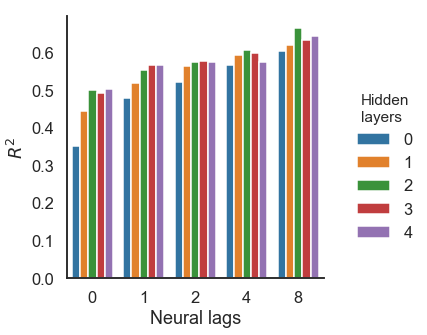

In [9]:
# PLOT
sns.set_style('white')
sns.set_context('talk')

y_axis = 'r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=all_test_r2s_df)
splt.ax.set_ylabel('$R^2$')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')

if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()